In [2]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm

from glob import glob



In [3]:
STOCK = "FB"
path = glob(f"data/{STOCK}/cleaned_data/*.*")
print(path)

['data/FB/cleaned_data\\FB_2019-01-03_34200000_57600000_orderbook_10.csv']


In [4]:
df = pd.read_csv(path[0])
# df.set_index(df.DateTime, inplace = True)
print(df.columns)
df.head()

Index(['DateTime', 'Event_Type', 'Order_ID', 'Size', 'Price', 'Direction',
       'Ask_Price_Level_1', 'Ask_Volume_Level_1', 'Bid_Price_Level_1',
       'Bid_Volume_Level_1', 'Ask_Price_Level_2', 'Ask_Volume_Level_2',
       'Bid_Price_Level_2', 'Bid_Volume_Level_2', 'Ask_Price_Level_3',
       'Ask_Volume_Level_3', 'Bid_Price_Level_3', 'Bid_Volume_Level_3',
       'Ask_Price_Level_4', 'Ask_Volume_Level_4', 'Bid_Price_Level_4',
       'Bid_Volume_Level_4', 'Ask_Price_Level_5', 'Ask_Volume_Level_5',
       'Bid_Price_Level_5', 'Bid_Volume_Level_5', 'Ask_Price_Level_6',
       'Ask_Volume_Level_6', 'Bid_Price_Level_6', 'Bid_Volume_Level_6',
       'Ask_Price_Level_7', 'Ask_Volume_Level_7', 'Bid_Price_Level_7',
       'Bid_Volume_Level_7', 'Ask_Price_Level_8', 'Ask_Volume_Level_8',
       'Bid_Price_Level_8', 'Bid_Volume_Level_8', 'Ask_Price_Level_9',
       'Ask_Volume_Level_9', 'Bid_Price_Level_9', 'Bid_Volume_Level_9',
       'Ask_Price_Level_10', 'Ask_Volume_Level_10', 'Bid_Price_Leve

,DateTime,Event_Type,Order_ID,Size,Price,Direction,Ask_Price_Level_1,Ask_Volume_Level_1,Bid_Price_Level_1,Bid_Volume_Level_1,...,Bid_Price_Level_8,Bid_Volume_Level_8,Ask_Price_Level_9,Ask_Volume_Level_9,Bid_Price_Level_9,Bid_Volume_Level_9,Ask_Price_Level_10,Ask_Volume_Level_10,Bid_Price_Level_10,Bid_Volume_Level_10
0,2019-01-03 09:30:00:690212,1,7611690.0,10,1348100.0,-1,134.80,30,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
1,2019-01-03 09:30:00:690246,1,7611990.0,100,1347800.0,-1,134.78,100,134.50,630,...,134.1,203,134.99,100,133.99,1,135.00,3781,133.90,80
2,2019-01-03 09:30:00:690267,3,7611690.0,10,1348100.0,-1,134.78,100,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
3,2019-01-03 09:30:00:690272,1,7612006.0,100,1347800.0,-1,134.78,200,134.50,630,...,134.1,203,135.00,3781,133.99,1,135.09,25,133.90,80
4,2019-01-03 09:30:00:690741,1,7612154.0,6,1345800.0,1,134.78,200,134.58,6,...,134.2,21,135.00,3781,134.10,203,135.09,25,133.99,1


In [5]:
df.DateTime = pd.to_datetime(df.DateTime, format = '%Y-%m-%d %H:%M:%S:%f') # Formatting time for faster plot

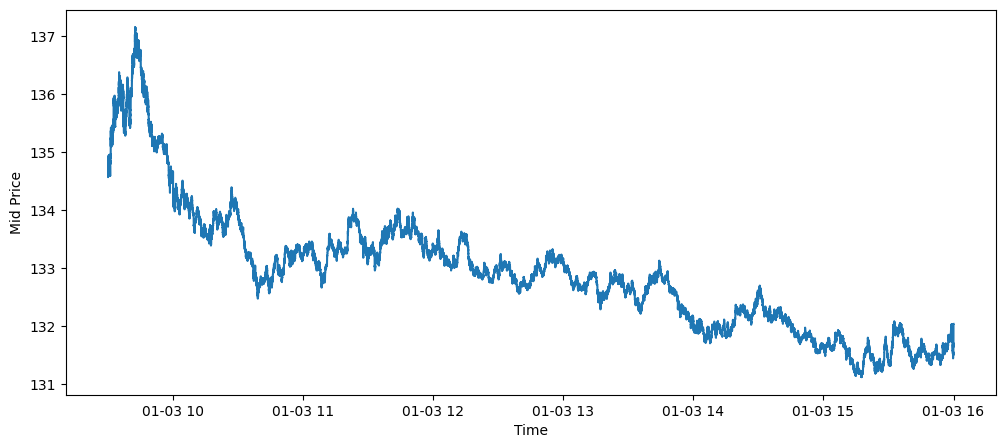

In [6]:
df["MidPrice"] = (df.Bid_Price_Level_1 + df.Ask_Price_Level_1) / 2
plt.figure(figsize = (12, 5), clear = True)
plt.plot(df.DateTime, df.MidPrice)
plt.xlabel("Time")
plt.ylabel("Mid Price")
plt.show()

In [7]:
# Mean spread
mean_spread = (df.Ask_Price_Level_1 - df.Bid_Price_Level_1).mean()
print(f"Average spread for stock {STOCK}: {round(mean_spread, 2)}")

Average spread for stock FB: 0.05


In [8]:
# Compute empericla tick size
# Split to two sides
ask_side = df.filter(like = "Ask_Price_Level")
bid_side = df.filter(like = "Bid_Price_Level")

# Compute differences for each side, difference across columns, remove first column which has NaN due to nothing to compare with
ask_diff = ask_side.diff(axis = 1).iloc[:, 1:].to_numpy().flatten()
bid_diff = bid_side.diff(axis = 1).iloc[:, 1:].to_numpy().flatten()

agg_diff = np.concatenate([ask_diff, bid_diff]) # Aggregate differences across both sides
empirical_tick_size = np.abs(agg_diff).mean() # Take absolute values and then mean

print(f"Empirical tick size for stock {STOCK}: {round(empirical_tick_size, 2)}")

Empirical tick size for stock FB: 0.01


#### Return analysis

In [9]:
BIN_SIZE = "10s"
groups_by_secs = df.groupby(pd.Grouper(key = "DateTime", freq = BIN_SIZE))

In [10]:
group_ticks_len = []
open_mid = []
high_mid = []
low_mid = []
close_mid = []
number_missing_seconds = 0

for k in groups_by_secs:
    if len(k[1] != 0):
        group_ticks_len.append(len(k[1])) # Number of trades over current interval
        open_mid.append(list(k[1].MidPrice)[0])   # First price
        high_mid.append(max(list(k[1].MidPrice))) # Maximum price achieved
        low_mid.append(min(list(k[1].MidPrice)))  # Minimum price achieved
        close_mid.append(list(k[1].MidPrice)[-1]) # Last price
    else:
        number_missing_seconds += 1

In [11]:
print(f"Average bins size: {round(np.mean(group_ticks_len), 2)} ticks.")
print(f"Std bins' length: {round(np.std(group_ticks_len), 2)} ticks.")
print(f"Number of missing bins (={BIN_SIZE}) in one trading day: {number_missing_seconds}")
print(f"Average mid price: {round(np.mean(close_mid), 2)}$")

Average bins size: 334.97 ticks.
Std bins' length: 230.97 ticks.
Number of missing bins (=10s) in one trading day: 0
Average mid price: 132.93$


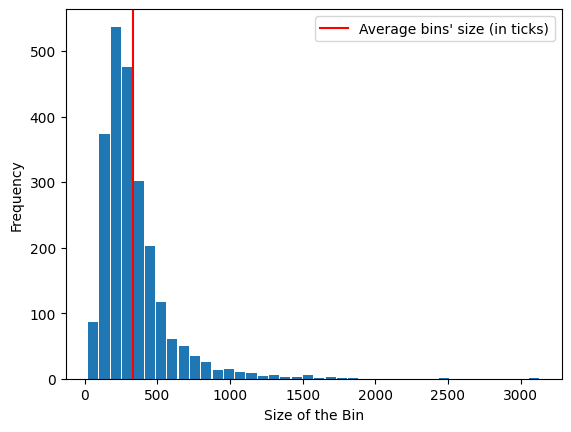

In [12]:
plt.hist(group_ticks_len, histtype = "bar", bins = 40, rwidth = 0.9)
plt.axvline(np.mean(group_ticks_len), color = "red", label = "Average bins' size (in ticks)")
plt.xlabel("Size of the Bin")
plt.ylabel("Frequency")
plt.legend()
plt.show()

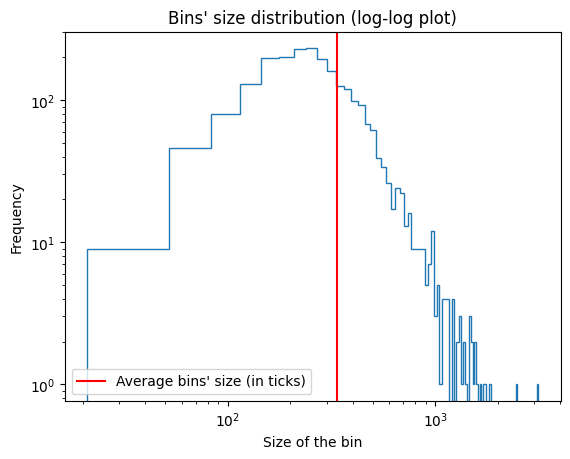

In [13]:
plt.hist(group_ticks_len, bins=100, histtype='step')
plt.axvline(np.mean(group_ticks_len), color='red', label="Average bins' size (in ticks)")
plt.xscale('log')
plt.yscale('log')
plt.title("Bins' size distribution (log-log plot)")
plt.xlabel('Size of the bin')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [14]:
ohlc = pd.DataFrame({'Open':open_mid, 'High':high_mid, 'Low':low_mid, 'Close':close_mid})

In [15]:
# (np.log(ohlc.Close) - np.log(ohlc.Close.shift(1)))
# np.log(ohlc.Close / ohlc.Close.shift(1)).dropna()
log_ret = np.log(ohlc.Close).diff()[1:]
log_ret

1       0.000185
2       0.000000
3      -0.001225
4      -0.000371
5      -0.000149
          ...   
2335   -0.000834
2336   -0.000948
2337   -0.001405
2338   -0.000950
2339    0.004326
Name: Close, Length: 2339, dtype: float64

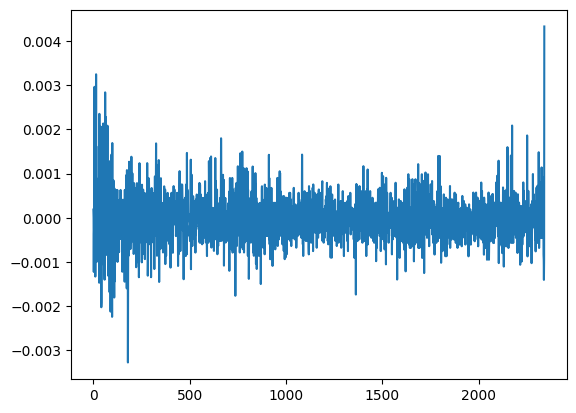

In [16]:
plt.plot(log_ret)

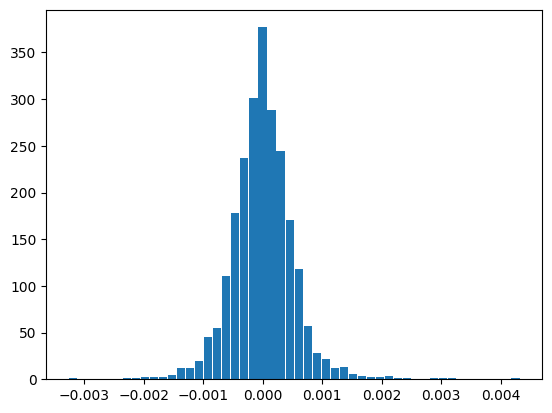

In [17]:
plt.hist(log_ret, bins = 50, rwidth = 0.9)
plt.show()

In [18]:
def compute_emperical_kurtosis(arr):
    m1 = np.mean(arr)
    m2 = np.mean((arr - m1)**2)
    m4 = np.mean((arr - m1)**4)
    return m4 / m2**2 - 3

print(sp.stats.kurtosis(log_ret))
print(compute_emperical_kurtosis(log_ret))

5.4012577244907956
5.4012577244907956


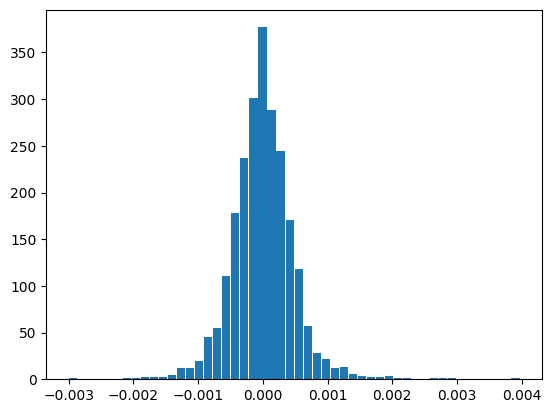

In [19]:
def daily_volatility(data):
    return np.std(data)

log_ret_normalised = np.log(ohlc.Close).diff().dropna() / daily_volatility(ohlc.Close)

N = len(log_ret_normalised)
mean = sum(log_ret_normalised) / N
std = np.sqrt(sum(log_ret_normalised - mean)**2 / N)

plt.hist(log_ret_normalised, bins = 50, rwidth = 0.9)
plt.show()

In [20]:
def ccdf(data):
    data = np.sort(data)
    x, counts = np.unique(data, return_counts = True) # return_counts: returns the count of elements, namely...
    events = np.cumsum(counts)
    n = data.size
    cdf = events / n
    empc = 1 - cdf
    return x, empc

def gaussian_ccdf(data):
    x = np.array(sorted(data))
    N = len(data)
    mean = sum(data) / N
    std = np.sqrt(sum((data - mean)**2) / N)
    c = 0.5 * (1 - sp.special.erf((x - mean) / (std * np.sqrt(2))))
    return (x, c)

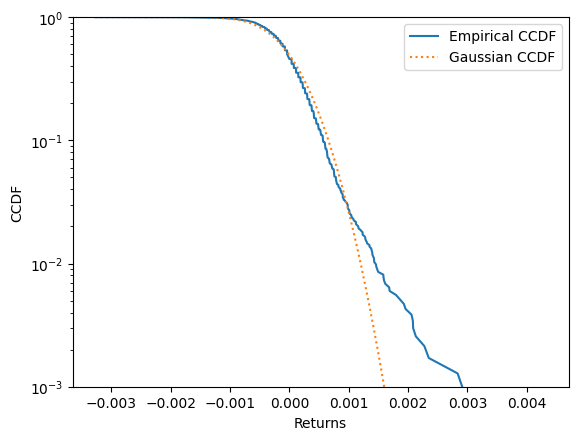

In [21]:
ccdf_rets_x, ccdf_rets_y = ccdf(log_ret)
ccdf_gaussian_x, ccdf_gaussian_y = gaussian_ccdf(log_ret)

plt.semilogy(ccdf_rets_x, ccdf_rets_y, label='Empirical CCDF')
plt.semilogy(ccdf_gaussian_x, ccdf_gaussian_y, label='Gaussian CCDF', ls='dotted')

plt.xlabel('Returns')
plt.ylabel('CCDF')
plt.ylim(10e-4, 1)
plt.legend()
plt.show()

#### Returns Autocorrelation Dynamics

In [22]:
lags = range(10)
data = [3, 16, 156, 47, 246, 176, 233, 140, 130, 
        101, 166, 201, 200, 116, 118, 247, 
        209, 52, 153, 232, 128, 27, 192, 168, 208, 
        187, 228, 86, 30, 151, 18, 254, 
        76, 112, 67, 244, 179, 150, 89, 49, 83, 147, 90, 
        33, 6, 158, 80, 35, 186, 127]

In [23]:
# Initialise results
mean = np.mean(data)
var = np.var(data)

# Normalised (centred) data
data_normalised = [x - mean for x in data]

print(f"Mean: {mean}")
print(f"Variance: {var}")
print(f"Normalised data: {data_normalised}")

Mean: 130.6
Variance: 5260.76
Normalised data: [-127.6, -114.6, 25.400000000000006, -83.6, 115.4, 45.400000000000006, 102.4, 9.400000000000006, -0.5999999999999943, -29.599999999999994, 35.400000000000006, 70.4, 69.4, -14.599999999999994, -12.599999999999994, 116.4, 78.4, -78.6, 22.400000000000006, 101.4, -2.5999999999999943, -103.6, 61.400000000000006, 37.400000000000006, 77.4, 56.400000000000006, 97.4, -44.599999999999994, -100.6, 20.400000000000006, -112.6, 123.4, -54.599999999999994, -18.599999999999994, -63.599999999999994, 113.4, 48.400000000000006, 19.400000000000006, -41.599999999999994, -81.6, -47.599999999999994, 16.400000000000006, -40.599999999999994, -97.6, -124.6, 27.400000000000006, -50.599999999999994, -95.6, 55.400000000000006, -3.5999999999999943]


In [24]:
# Compute Autocorrelations
acorr = len(lags) * [0]

for l in lags:
    c = 1
    if (l > 0):
        tmp = []
        for i in range(len(data) - l):
            tmp.append(data_normalised[l:][i] * data_normalised[:-l][i])
        
        c = sum(tmp) / (len(data) - l) / var
    
    acorr[l] = c

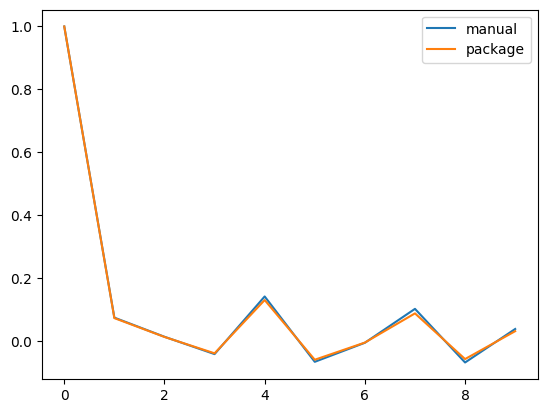

In [25]:
plt.plot(lags, acorr, label = "manual")
plt.plot(lags, sm.tsa.acf(data, nlags = lags[-1]), label = "package")
plt.legend()
plt.show()

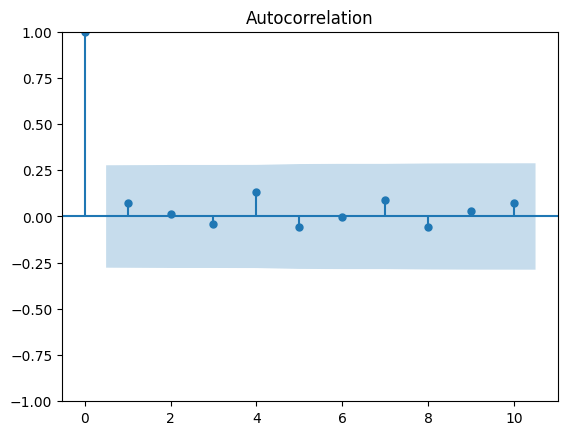

In [26]:
sm.graphics.tsa.plot_acf(data, lags = 10, alpha = 0.05)
plt.show()

In [1]:
log_ret_abs = np.abs(np.array(log_ret_normalised))

plt.plot(sm.tsa.acf(log_ret_abs, nlags = 100), label = "package")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()

sm.graphics.tsa.plot_acf(log_ret_abs, lags = 100, alpha = 0.05)
plt.show()

NameError: name 'np' is not defined

#### Variogram

In [28]:
vdata = np.array(log_ret_normalised)
var = np.var(log_ret_normalised)

In [29]:
lags = range(100)
vvalues = len(lags) * [0]

for l in lags:
    c = 0

    if l > 0:
        tmp = []
        for i in range(len(vdata) - l):
            tmp.append((vdata[l:][i] - vdata[:-l][i])**2)
        c = sum(tmp) / (2 * len(vdata)) / var
    
    vvalues[l] = c

Text(0.5, 1.0, 'Variogram')

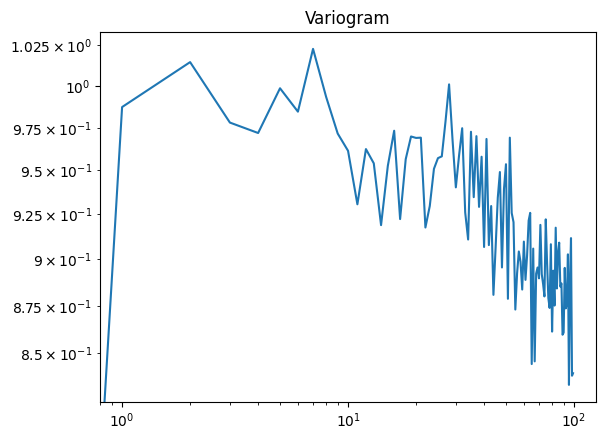

In [30]:
plt.plot(lags, vvalues)
plt.xscale('log')
plt.yscale('log')
plt.title('Variogram')